# Housing Maintenance Violation Code Analysis
 By Amy Chen

__This is an analysis of the data reported by the Department of Housing Preservation and Development (HPD). HPD issues violations to rental dwelling units that have violated either Housing Maintenance Code or the New York State Multiple Dwelling Law. __



Tenants can directly consult their landlord or file an official complaint if an issue is discovered in their apartment. These complaints are directed to the HPD, who in turn contacts the building's managing agent informing them of the complaint. The HPD will then follow up the complaint to ensure that the issue has been resolved and thus would close complaint. If the issue continues to be unresolved, the HPD would send a Code Inspector to check for housing or safety violations. The complaints are categorized into either class A, B, C, and I, with class A being least sever and class C being most severe, such as problems with heating and hot water (Class I cases are unique and indicate a serious hazard). The violations persist on file and the complaint cases remain open until the HPD can confirm that the owner has sufficiently corrected the condition.

# Set Up

<B> Downloading Packages

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

# Retrieving Data

<B> Here is a look at the housing violation data. As of when the file was downloaded, there are 4,955,054 housing violations and the dataset is continuously getting updated. We will take a sample of that dataset and work with that data

In [9]:
#housing = pd.read_csv('Housing_Maintenance_Code_Violations.csv')
housing = pd.read_csv('sample_housing.csv')

/Users/claudia/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (28,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
sample = housing.sample(frac=0.9)
sample.to_csv('sample_housing.csv')

In [11]:
#housing = housing.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','Unnamed: 0.1.1.2'], axis=1)

<B> Our sample consists of 157,434 violations (which is approximately 3.1% of the complete dataset)

In [12]:
len(housing)

127522

In [13]:
housing.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.2',
       'ViolationID', 'BuildingID', 'RegistrationID', 'BoroID', 'Borough',
       'HouseNumber', 'LowHouseNumber', 'HighHouseNumber', 'StreetName',
       'StreetCode', 'Postcode', 'Apartment', 'Story', 'Block', 'Lot', 'Class',
       'InspectionDate', 'ApprovedDate', 'OriginalCertifyByDate',
       'OriginalCorrectByDate', 'NewCertifyByDate', 'NewCorrectByDate',
       'CertifiedDate', 'OrderNumber', 'NOVID', 'NOVDescription',
       'NOVIssuedDate', 'CurrentStatusID', 'CurrentStatus',
       'CurrentStatusDate', 'NovType', 'ViolationStatus', 'Latitude',
       'Longitude', 'CommunityBoard', 'CouncilDistrict', 'CensusTract', 'BIN',
       'BBL', 'NTA'],
      dtype='object')

In [14]:
housing

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.2,ViolationID,BuildingID,RegistrationID,...,NovType,ViolationStatus,Latitude,Longitude,CommunityBoard,CouncilDistrict,CensusTract,BIN,BBL,NTA
0,73268,36347,17661,232856,347837,2189550,2189550,10030393,355783,340516,...,Original,Close,40.676022,-73.981549,6.0,39.0,133.0,3020248.0,3.009580e+09,Park Slope-Gowanus
1,137952,25037,56077,206447,262704,4531680,4531680,12476430,52532,217021,...,Original,Open,40.882303,-73.856760,12.0,12.0,396.0,2058558.0,2.046780e+09,Williamsbridge-Olinville
2,67483,84736,128296,266062,84345,3136794,3136794,6341165,784320,0,...,Original,Close,40.636928,-74.077973,1.0,49.0,17.0,5113133.0,5.005690e+09,Stapleton-Rosebank
3,11065,73782,82409,60760,102037,3471871,3471871,9070188,866183,379416,...,Original,Close,40.673322,-73.915672,16.0,41.0,363.0,3393277.0,3.014590e+09,Ocean Hill
4,28215,113791,172,65818,324952,3616925,3616925,9510434,164978,368528,...,Original,Open,40.625221,-74.000241,10.0,38.0,194.0,3142072.0,3.057470e+09,Dyker Heights
5,91214,156974,127337,171439,293901,1960736,1960736,872794,119284,203406,...,Reissued,Close,40.828908,-73.923092,4.0,8.0,195.0,2002916.0,2.024760e+09,West Concourse
6,7503,7486,223315,63457,86977,1563314,1563314,11868349,107776,215685,...,Original,Open,40.854814,-73.900049,5.0,15.0,381.0,2013714.0,2.031570e+09,Mount Hope
7,139695,54155,207867,159084,113536,1207402,1207402,11488849,119069,200823,...,Original,Close,40.846460,-73.911032,5.0,14.0,22701.0,2008198.0,2.028490e+09,Mount Hope
8,68320,9357,195666,283481,236901,1049424,1049424,11323370,109445,204361,...,Original,Close,40.836483,-73.914326,4.0,16.0,17902.0,2007964.0,2.028300e+09,East Concourse-Concourse Village
9,110497,156328,109894,268729,210612,4784818,4784818,12268346,357887,330679,...,Original,Close,40.695494,-73.911475,4.0,37.0,435.0,3077328.0,3.033780e+09,Bushwick North


__There are many dates that are being used in this dataset. We will convert the inspection date and approval date into datetime since they are currently strings. By converting them, we will create a new column called "Time Until Approval" to see how long it takes the Department of Building to approve. Within this dataset, 65% of the violations are still open. __

To find the percentage of violations that are still open, we create a variable grouped by the column "ViolationStatus", and then count the amount of open and closed violations. Then we divide the number of open violations by the total.

In [15]:
open_close = housing.groupby('ViolationStatus').count()
open_close['ViolationID'].iloc[1] / open_close['ViolationID'].iloc[0]
#Shouldn't it be divided by the total

0.6526314425307466

Here we are converting inspection and approval date into datetime.

In [20]:
housing['InspectionDate'] = pd.to_datetime(housing['InspectionDate'], format="%m/%d/%Y", errors = 'coerce')
housing['ApprovedDate'] = pd.to_datetime(housing['ApprovedDate'], format="%m/%d/%Y", errors = 'coerce')

In [21]:
housing['Time_Until_Approval'] = (abs(housing['ApprovedDate'] - housing['InspectionDate']))
housing['Time_Until_Approval'] = (housing['Time_Until_Approval'] / np.timedelta64(1, 'D')).fillna(0).astype(int)

<B> We will look at data starting from the 1980s since there aren't many data points in the file for anything before then. Within the last 30-40 years, there seems to be an exponential growth in housing violations. The graph that is displayed shows the change over time in years.

In [22]:
housing_past_1980 = housing[(housing.InspectionDate > '1980-01-01')]

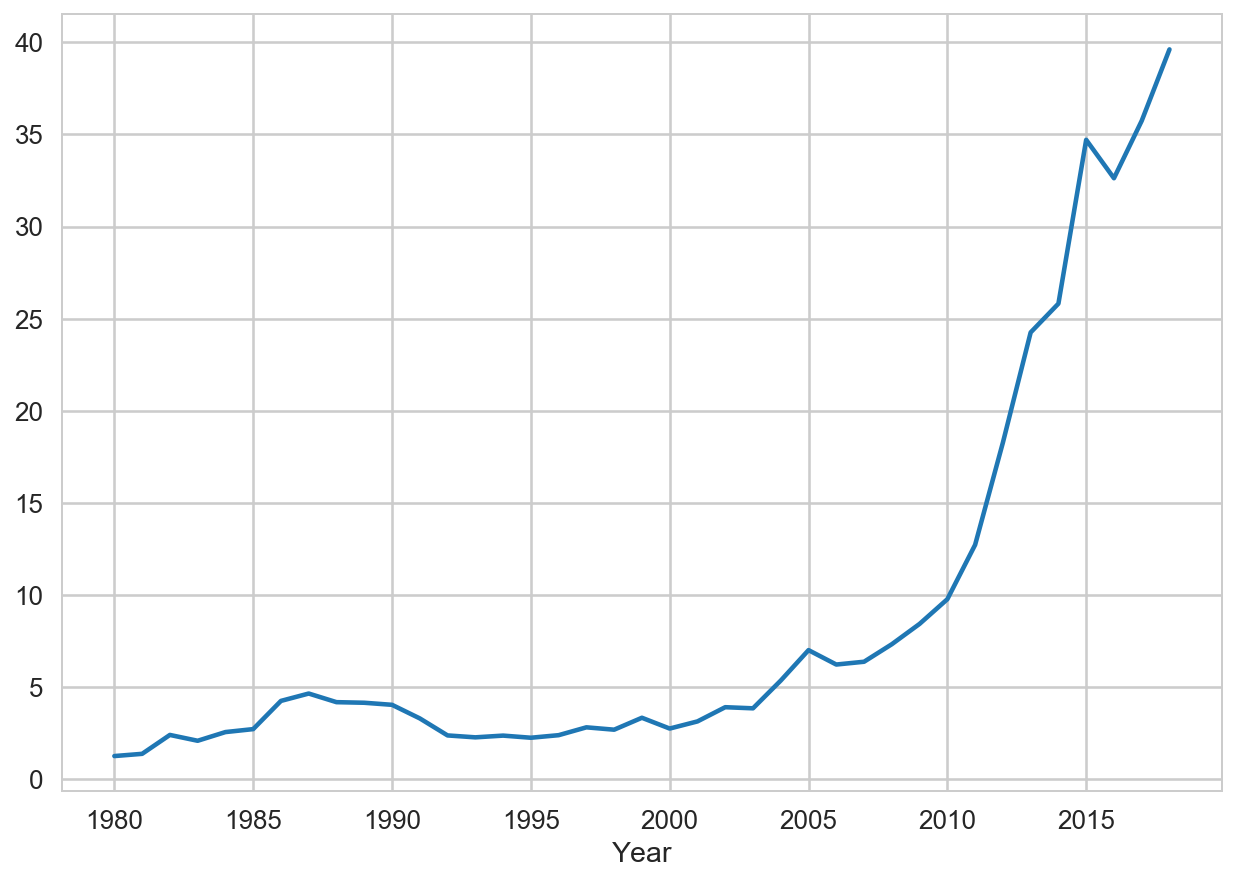

In [23]:
matplotlib.pyplot.xlabel("Year")
housing_past_1980.InspectionDate.value_counts().sort_index().resample('AS').mean().plot()

__We will now look at how many unique violations there are. The order number references to the abstract description of the violation condition which cites a specific section of the law which is in violation. From the code below, we find that there are <b>389</b> unique violation. That's 4955054:389 individual violations to violation code. 508 is the most popular order number.__

1. 508: REPAIR THE BROKEN OR DEFECTIVE PLASTERED SURFACES AND PAINT IN A UNIFORM COLOR
2. 501: REPAIR THE BROKEN OR DEFECTIVE
3. 502: PROPERLY REPAIR WITH SIMILAR MATERIAL THE BROKEN OR DEFECTIVE
4. 780: OWNER FAILED TO FILE A VALID REGISTRATION STATEMENT WITH THE DEPARTMENT AS REQUIRED BY ADM CODE §27-2097 AND IS THEREFORE SUBJECT TO CIVIL PENALTIES, PROHIBITED FROM CERTIFYING VIOLATIONS, AND DENIED THE RIGHT TO RECOVER POSSESSION OF PREMISES FOR NONPAYMENT OF RENT UNTIL A VALID REGISTRATION STATEMENT IS FILED.
5. 556: PAINT WITH LIGHT COLORED PAINT TO THE SATISFACTION OF THIS DEPARTMENT
6. 702: REPAIR OR REPLACE THE SMOKE DETECTOR
7. 510: 309 M/D LAW ABATE THE NUISANCE CONSISTING OF
8. 505: REPLACE WITH NEW THE BROKEN OR DEFECTIVE
9. 583: PROPERLY REPAIR THE SOURCE AND ABATE THE EVIDENCE OF A WATER LEAK
10. 550: TRACE AND REPAIR THE SOURCE AND ABATE THE NUISANCE CONSISTING OF MOLD ...

To find the number of unique orders, we converted the order in the column "OrderNumber" into a string.

In [20]:
housing['OrderNumber'] = [str(order) for order in housing['OrderNumber']]
print(housing['OrderNumber'].nunique())

298


This graph displays the ten most popular violations by their order numbers.

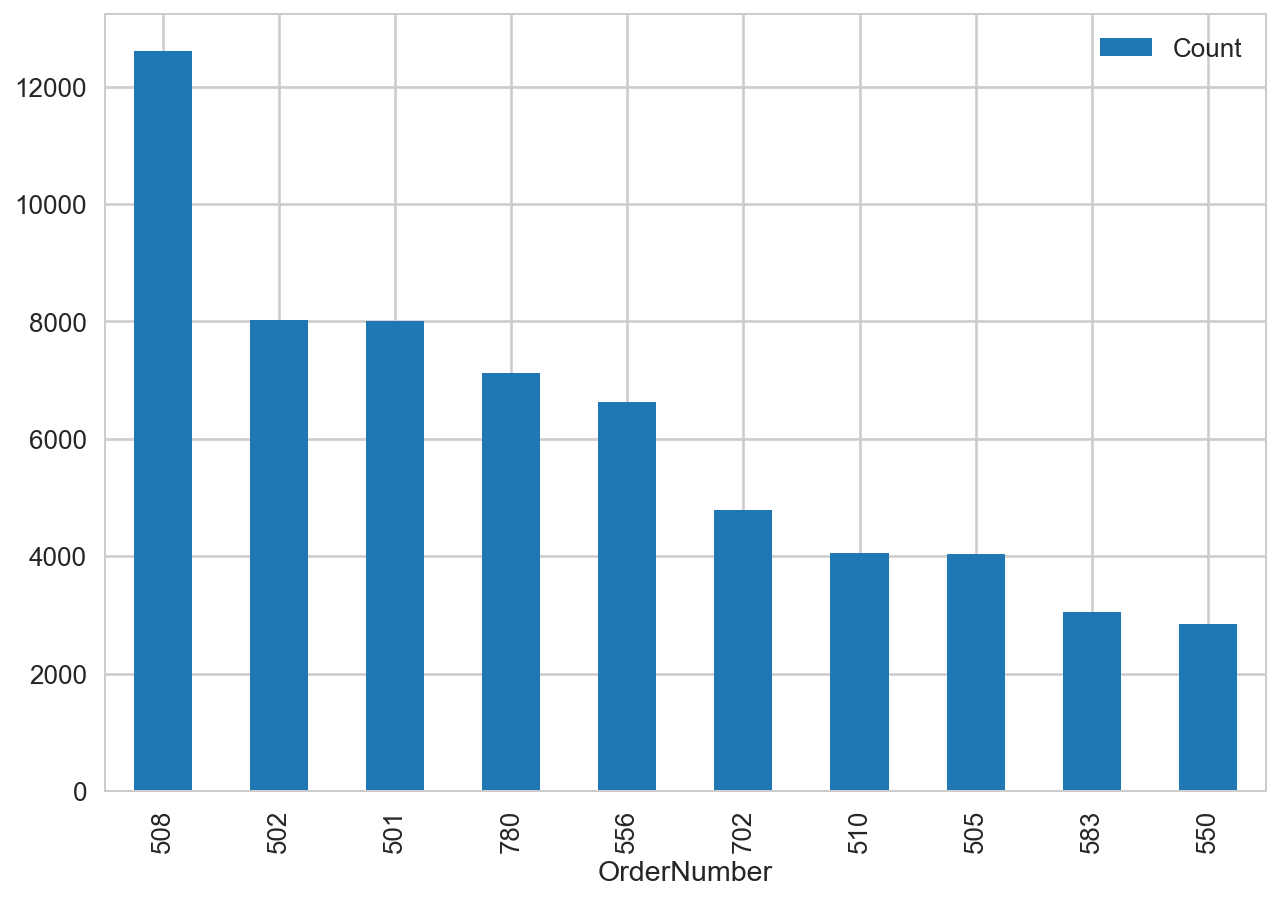

In [21]:
orderNumberViolation = housing[['ViolationID', 'OrderNumber']].groupby('OrderNumber').count().rename(columns={"ViolationID":"Count"})
orderNumberViolation.sort_values('Count', ascending=False).head(10).plot(kind='bar')

__We will now look at the number of violations in each borough. Here, Brooklyn has the most violation. The violations are also plotted on the NYC map which I got from geojson. Data without a latitude and longitude are dropped since they were causing errors. The lighter the purple, the less concentration of violation.__

In [22]:
housing = housing.dropna(subset=['Latitude', 'Longitude'])

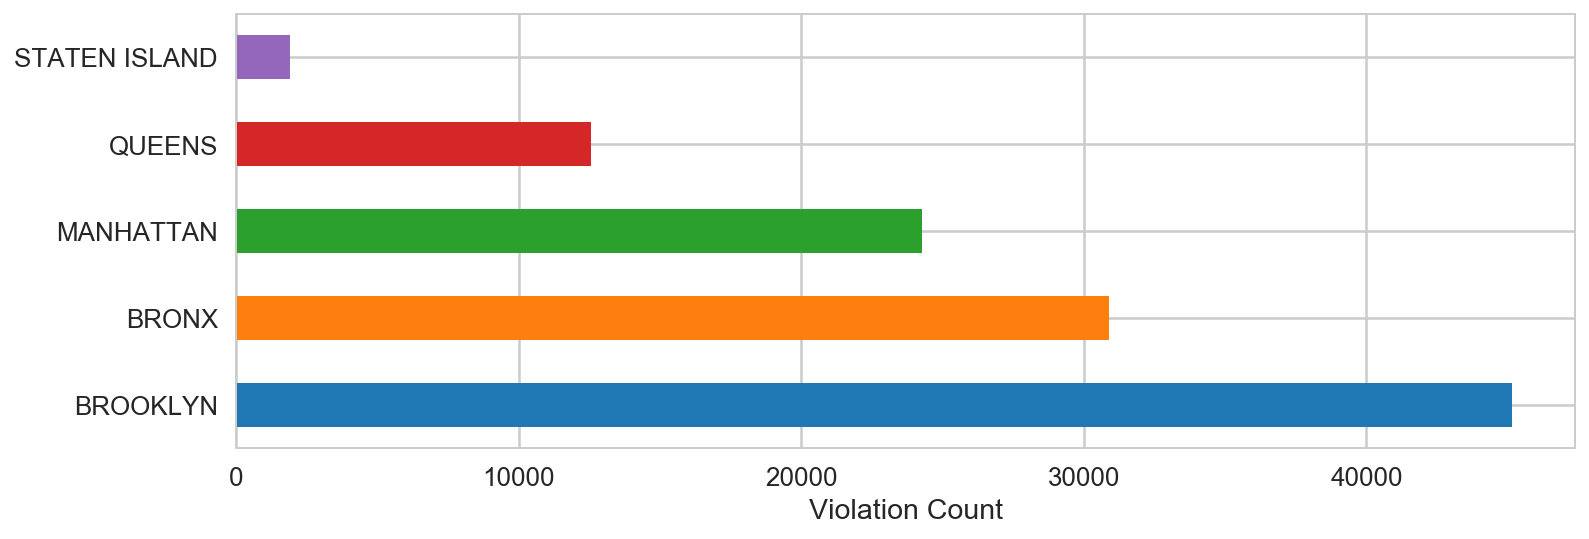

In [16]:
matplotlib.pyplot.xlabel("Violation Count")
housing.Borough.value_counts().plot(kind='barh', figsize=(12,4))

In [24]:
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4067k    0 4067k    0     0  2895k      0 --:--:--  0:00:01 --:--:-- 2895k


In [25]:
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')

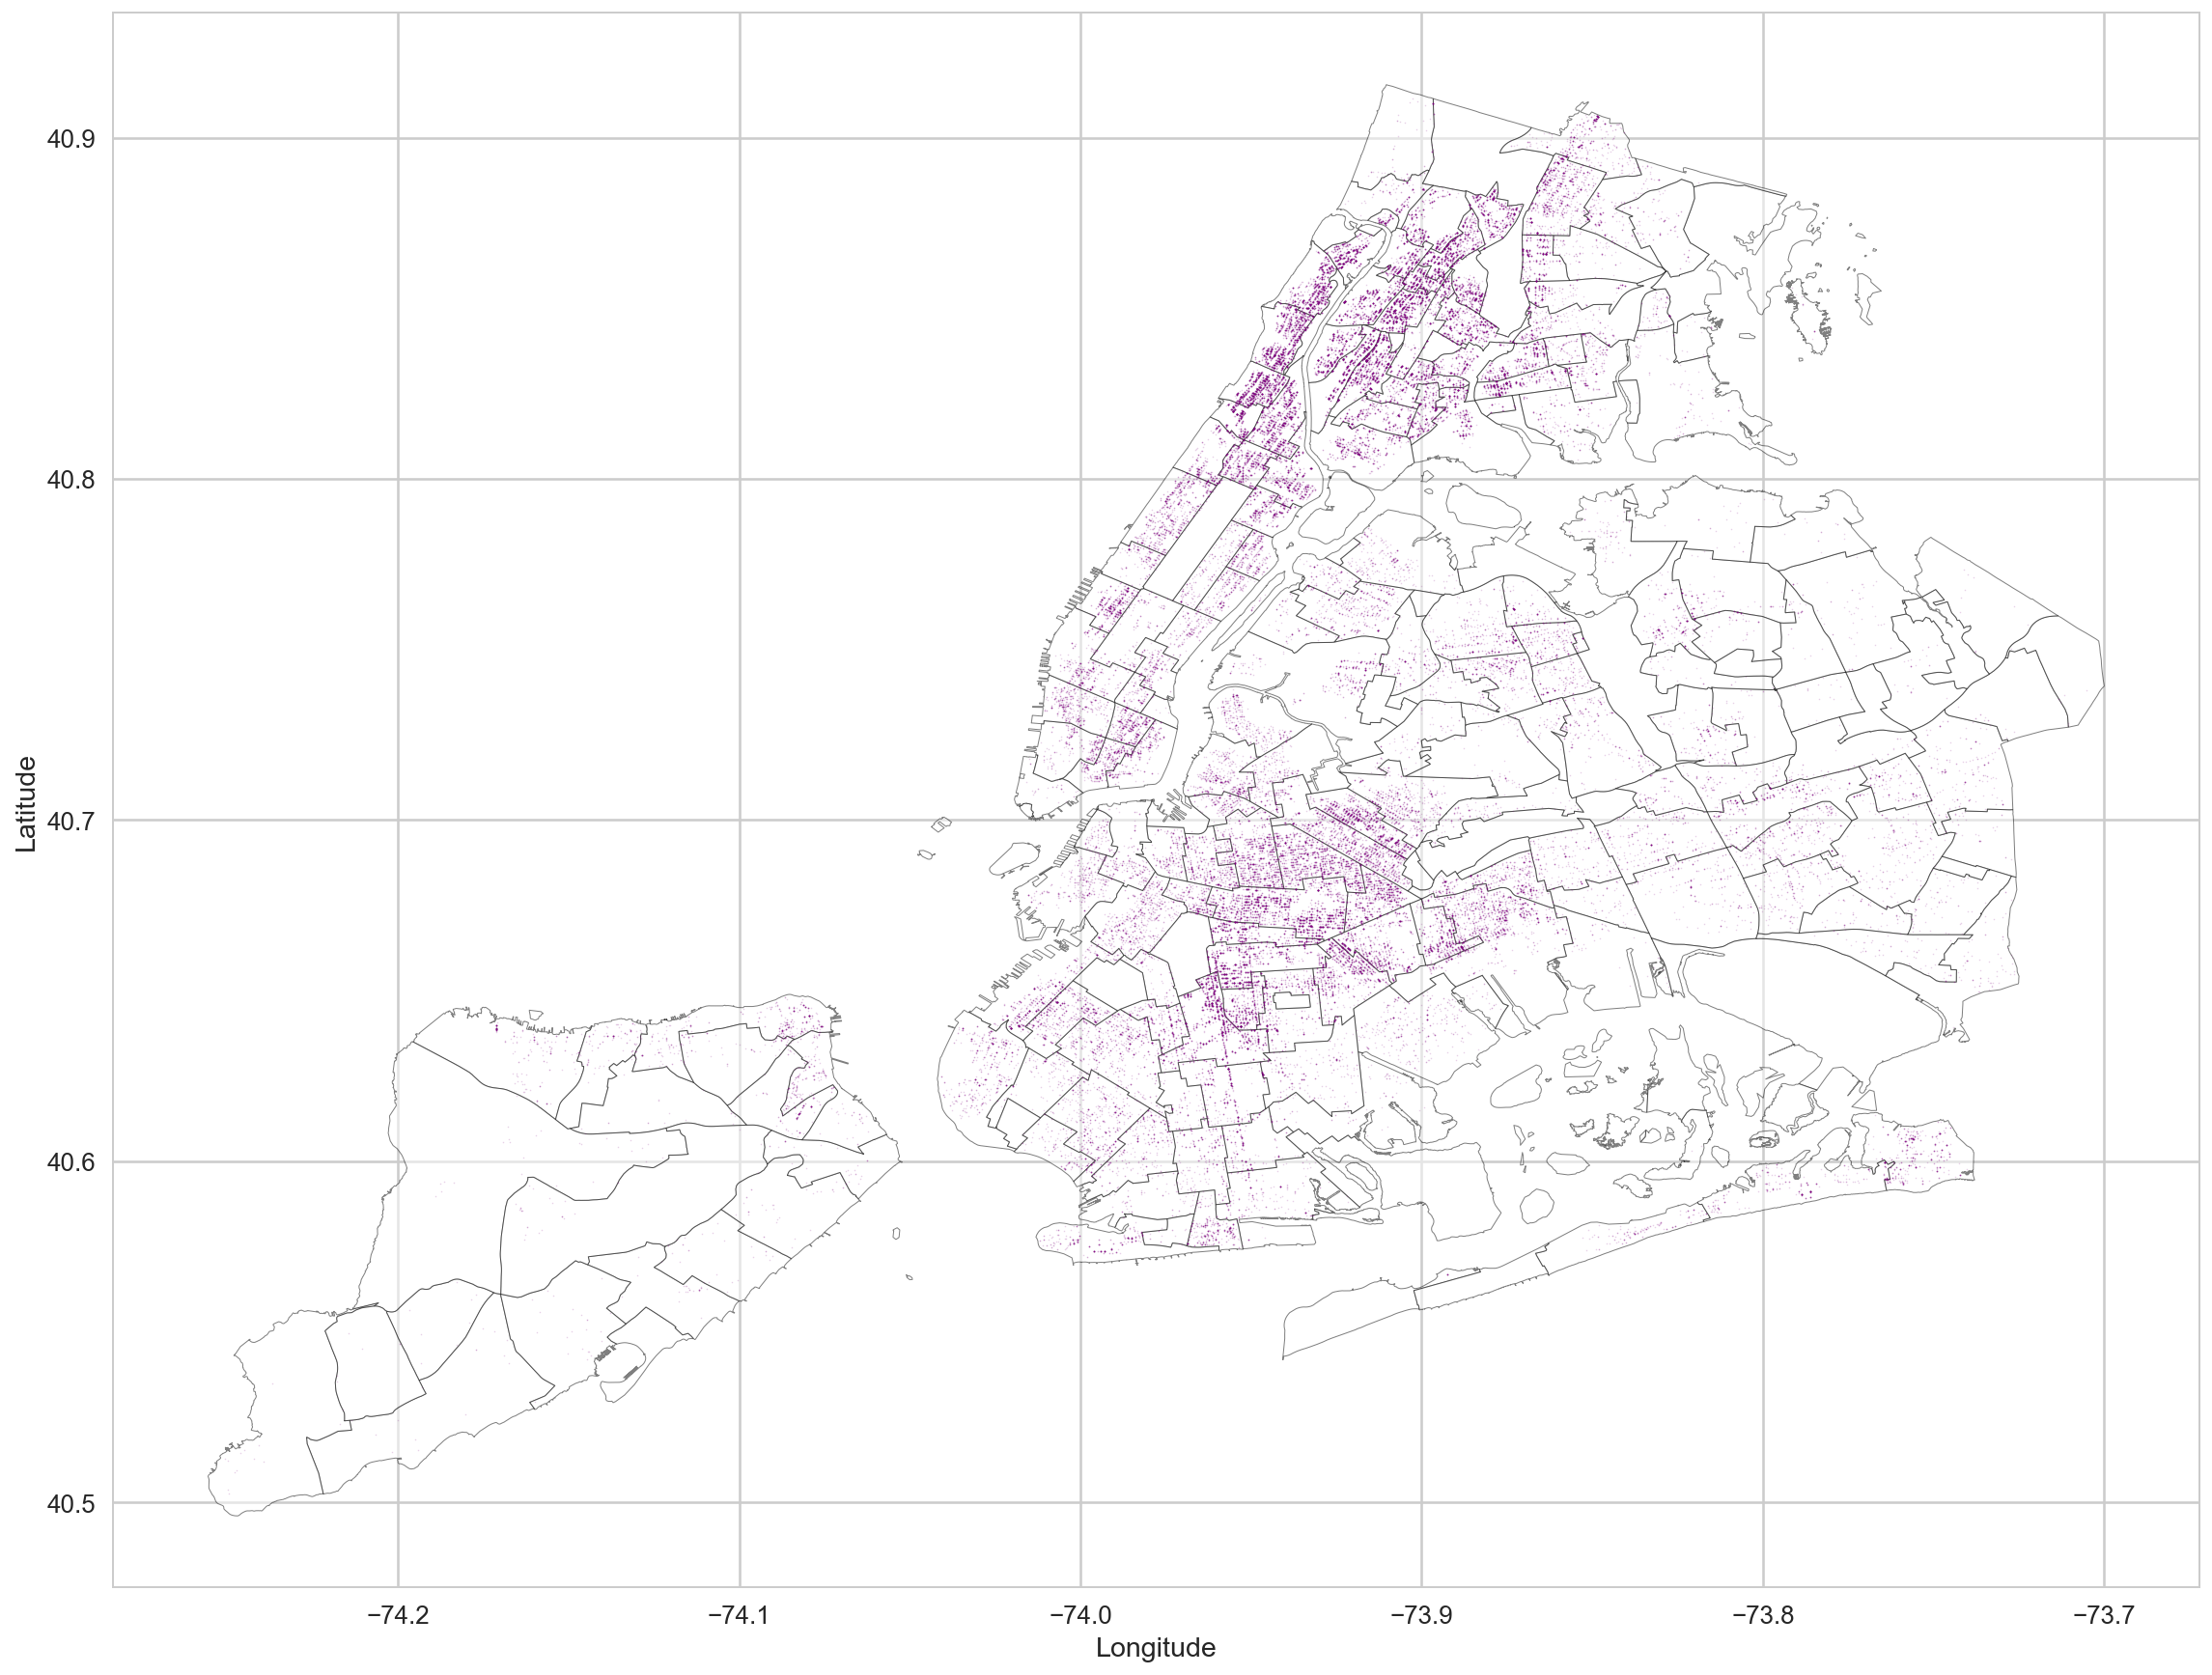

In [26]:
ny_map = df_nyc.plot(linewidth=0.5, color='White', edgecolor = 'Black', figsize = (20,15), alpha=0.5)

housing_loc = housing.sample(frac=0.7).plot.scatter(
    x="Longitude", 
    y="Latitude",
    figsize=(20,15),
    s=0.3,
    color='purple',
    alpha=0.1,
    ax=ny_map
)

__The following graph below takes 10% of the sample data and plots a KDE map from it. The map may be a bit inaccurate, but generally speaking, it should be okay because higher concentrations of violation will still be mapped out.__

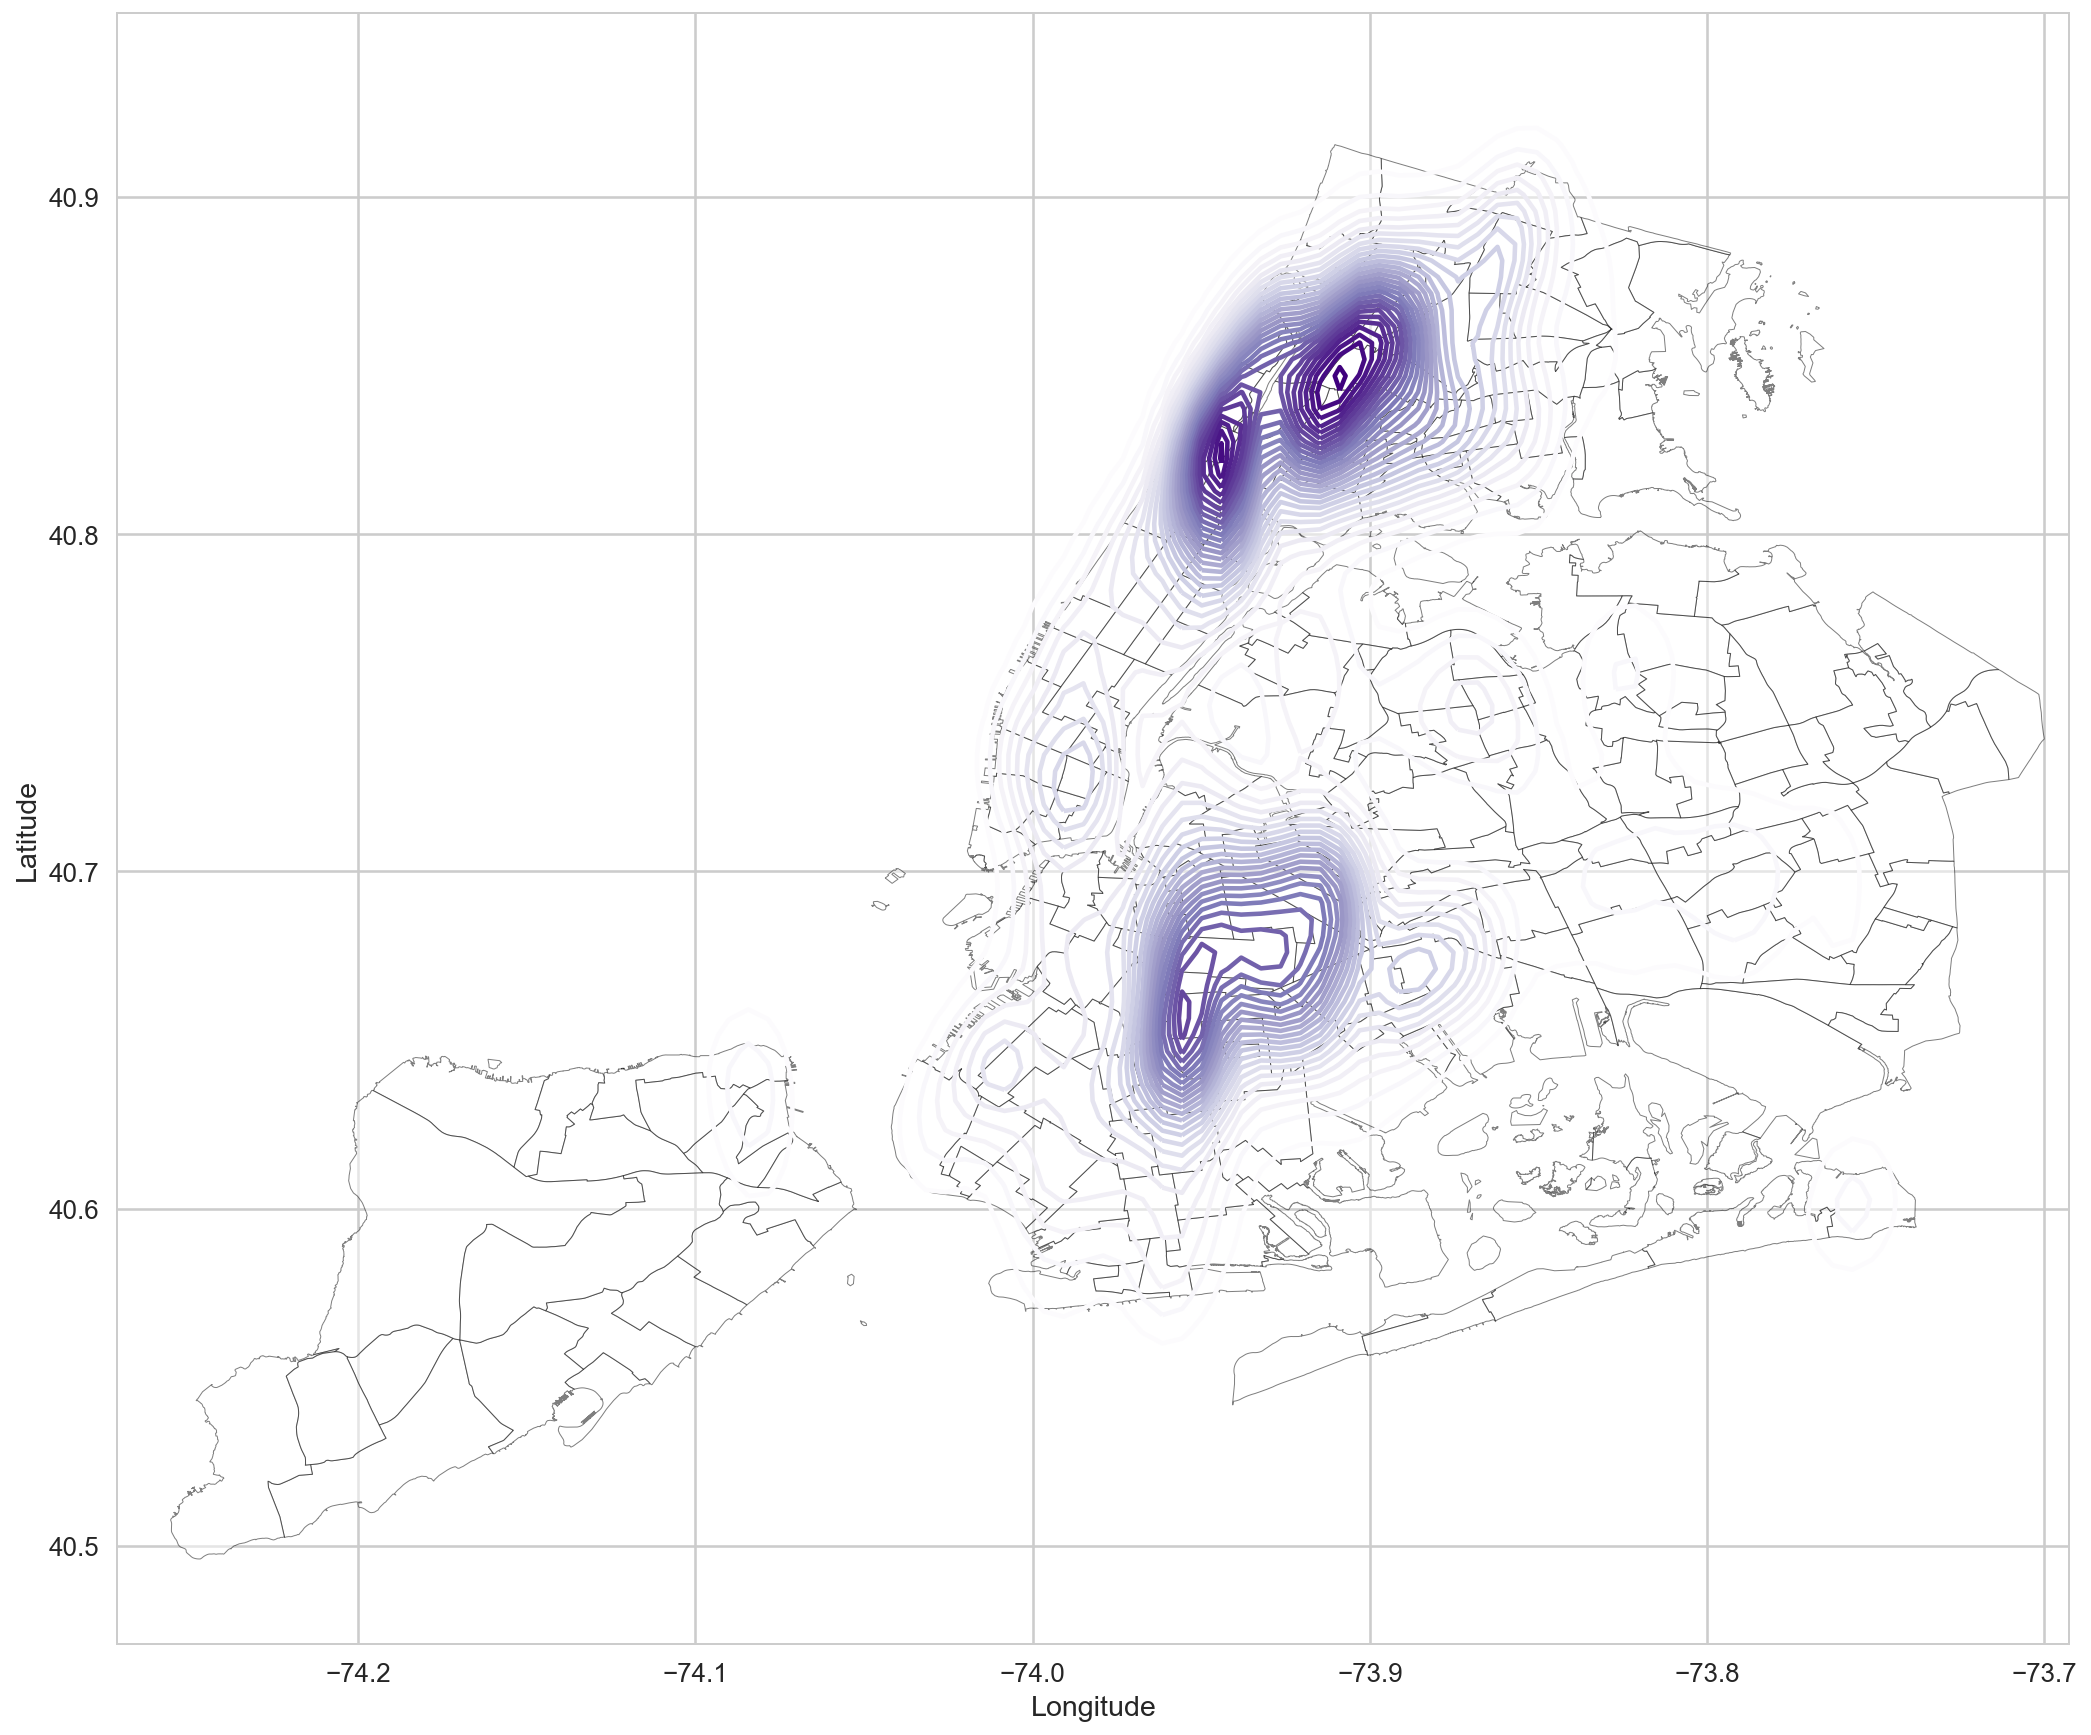

In [27]:
ny_map = df_nyc.plot(linewidth=0.5, color='White',edgecolor = 'Black', figsize = (20,15), alpha=0.5)

sample = housing.sample(frac=0.1)
sns.kdeplot(
    sample.Longitude, sample.Latitude,
    gridsize=100,
    cmap=plt.cm.Purples,
    shade_lowest=False,
    n_levels=30,
    ax=ny_map
)

<B>The following graph represents the time it takes for the department of building to approve a violation depending on the class of the violation. <B>

<I>A</I> class violation is the least severe and the <I>C</I> class is the most severe. *I* class is considered hazardous.

We will disregard Staten Island and the Bronx here because of they have less cases of buildings with housing violations.

In the graph repsented below, <I>A</I> class violations (least severe) take the most time to get approved in Queens, followed by Brooklyn, then Manhattan. The <I>C</I> class violation takes the longest to get approved in Brooklyn, then Queens, then Manhattan. 

In Manhattan, the approval rate is generally much faster than the other boroughs. Queens seems to have the slowest approval rate in all cases except class <I>C</I>, with Brooklyn being the slowest in that case.

To obtain this bar graph, we take "Time_Until_Approval" and graph it against "Class". 

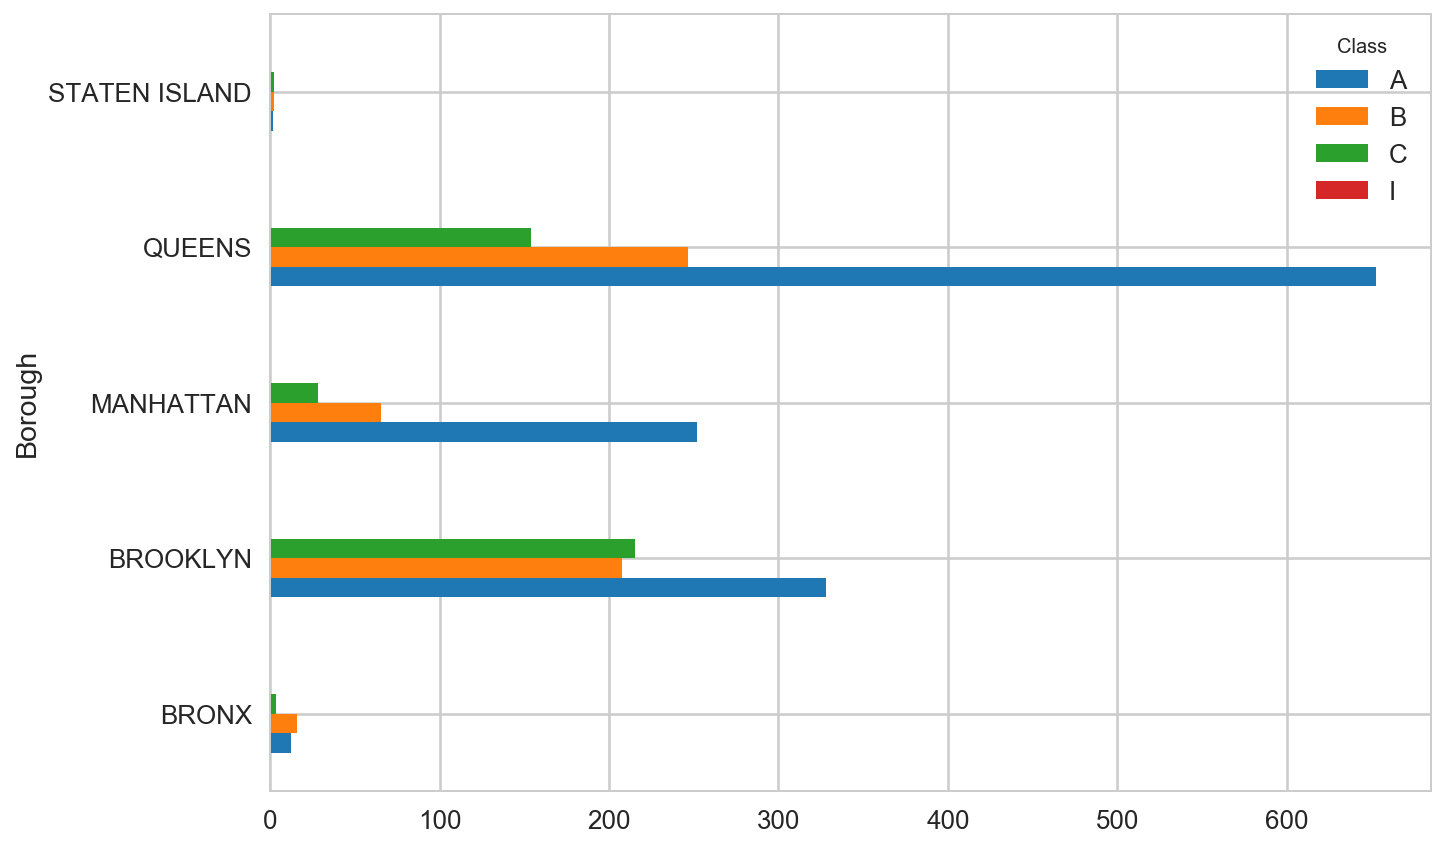

In [28]:
approval = housing[['Time_Until_Approval', 'Class']].set_index("Class")
approval_time= pd.pivot_table(
    data = housing.sample(3000),
    index='Borough',
    columns='Class',
    values='Time_Until_Approval'
).plot.barh()
#What are the units for Time Until Approval?

__There's not a lot of I class (hazardous) violations compared to the other 3 classes, so let's look into that. Clearly from the KDE map and the value_counts, Brooklyn has the greatest number of I class violations. The top 9 streets with at least 1000 hazardous violations are found in Brooklyn's street of __
1. GREENE AVENUE       1642
2. BEDFORD AVENUE      1259
3. PUTNAM AVENUE       1223
4. JEFFERSON AVENUE    1206
5. MADISON STREET      1191
6. HANCOCK STREET      1180
7. 3 AVENUE            1173
8. 5 AVENUE            1140
9. BROADWAY            1041


To obtain this data, we first create a new dataframe which we named "classI", which contains the 'HouseNumber', 'StreetName', 'Borough', 'Latitude', and 'Longitude' columns for only the class I violations.

In [29]:
classI = housing.loc[housing['Class']=="I", ['HouseNumber', 'StreetName', 'Borough', 'Latitude', 'Longitude']]
classI

,HouseNumber,StreetName,Borough,Latitude,Longitude
35,115,WEST 118 STREET,MANHATTAN,40.803646,-73.949460
48,1137,CROES AVENUE,BRONX,40.828037,-73.870326
53,2507,CLARENDON ROAD,BROOKLYN,40.642967,-73.953376
82,12-07,31 AVENUE,QUEENS,40.768739,-73.933223
116,4,DOWNING STREET,BROOKLYN,40.685580,-73.961286
135,6903,15 AVENUE,BROOKLYN,40.620947,-73.999579
196,545,WEST 152 STREET,MANHATTAN,40.830194,-73.945653
198,106-35,156 STREET,QUEENS,40.696896,-73.798120
248,31-33,105 STREET,QUEENS,40.760551,-73.864216
256,147-24,230 STREET,QUEENS,40.657466,-73.752358


Then we found which Borough had the most class I violations, which turned out to be Brooklyn.

In [30]:
classI['Borough'].value_counts()

BROOKLYN         3654
QUEENS           1543
BRONX            1083
MANHATTAN        1049
STATEN ISLAND     104
Name: Borough, dtype: int64

Finally, we obtained a list containing the top ten streets for class I violations.

In [31]:
classI["StreetName"].value_counts().head(10)

GREENE AVENUE     46
BROADWAY          36
60 STREET         34
HANCOCK STREET    34
FULTON STREET     33
3 AVENUE          29
MADISON STREET    29
DEAN STREET       29
PUTNAM AVENUE     28
41 STREET         28
Name: StreetName, dtype: int64

__This is a map of all the I class violations found in NYC__ 

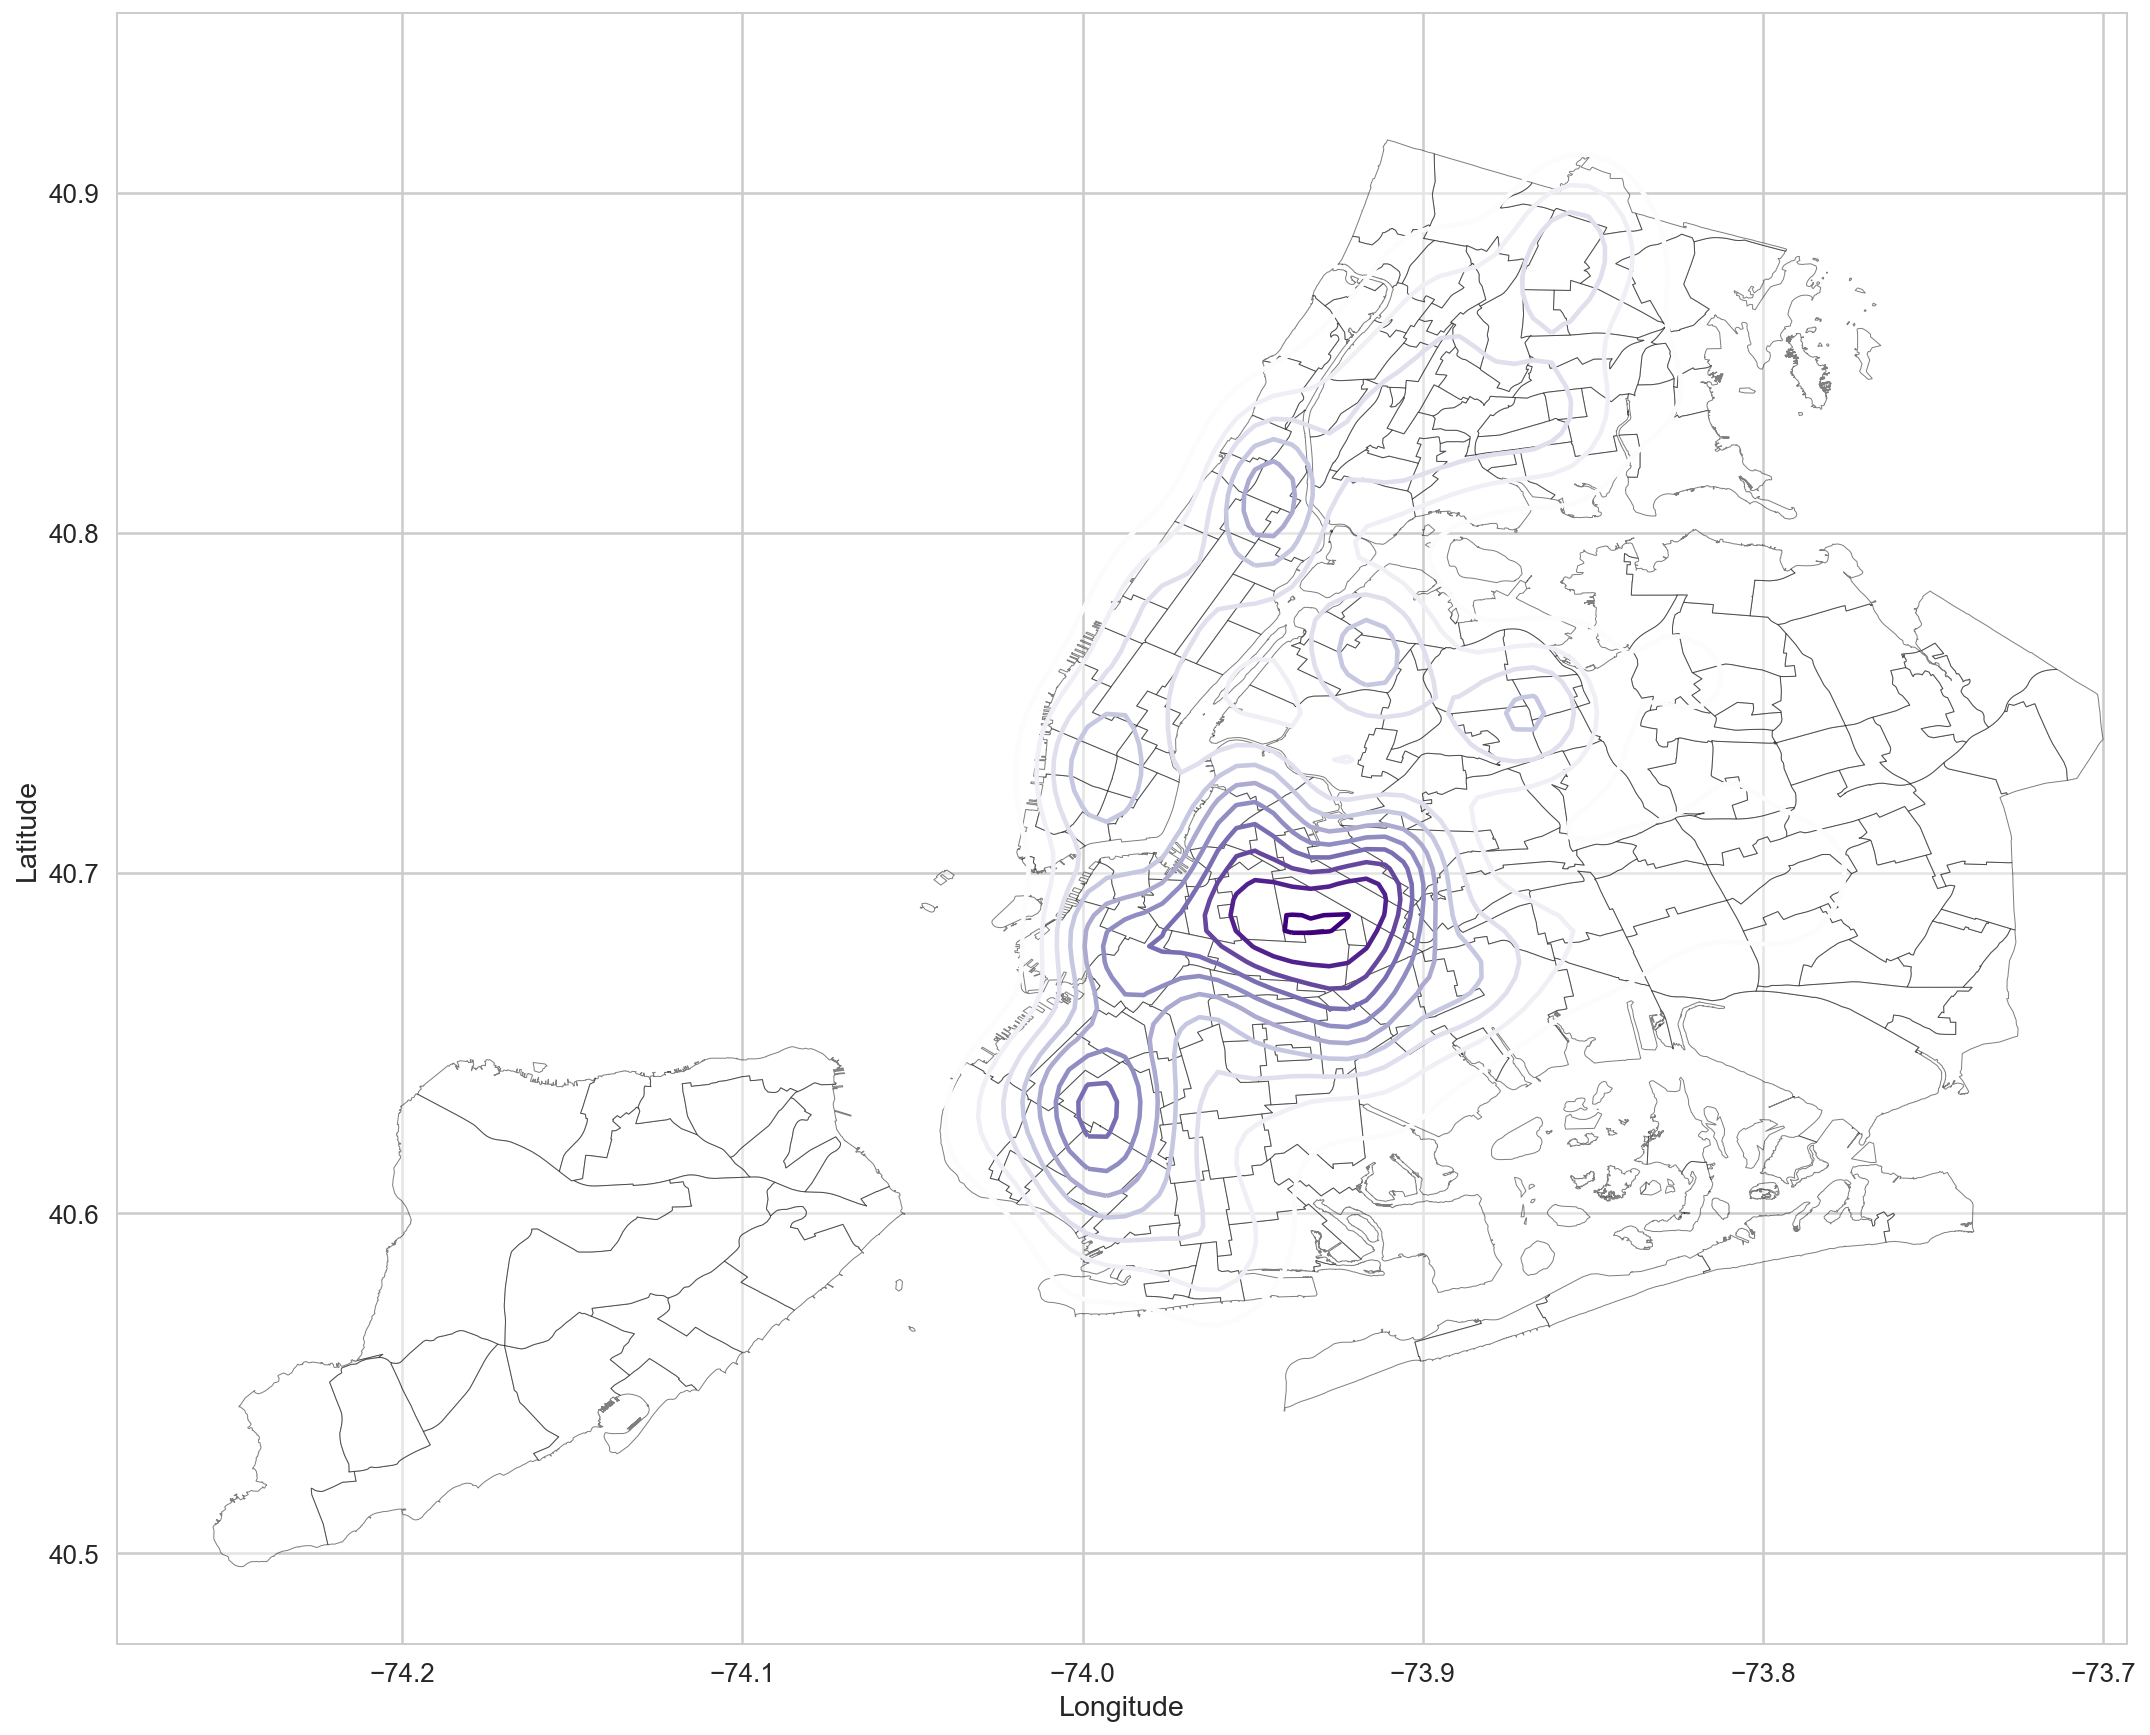

In [32]:
ny_map = df_nyc.plot(linewidth=0.5, color='White', edgecolor = 'Black', figsize = (20,15), alpha=0.5)

sns.kdeplot(
    classI.Longitude, classI.Latitude,
    gridsize=100,
    cmap=plt.cm.Purples,
    shade=False,
    shade_lowest=False,
    n_levels=10,
    ax=ny_map
)

# Housing Complaints 

In [3]:
complaints = pd.read_csv("https://data.cityofnewyork.us/api/views/uwyv-629c/rows.csv?accessType=DOWNLOAD")

In [34]:
len(complaints)

1559398

Take a 10% sample of the data to make running code easier.

In [4]:
complaints_sample = complaints.sample(frac=0.1)

In [36]:
len(complaints_sample)

155940

In [37]:
complaints_sample.columns

Index(['ComplaintID', 'BuildingID', 'BoroughID', 'Borough', 'HouseNumber',
       'StreetName', 'Zip', 'Block', 'Lot', 'Apartment', 'CommunityBoard',
       'ReceivedDate', 'StatusID', 'Status', 'StatusDate'],
      dtype='object')

In [38]:
complaints_sample

,ComplaintID,BuildingID,BoroughID,Borough,HouseNumber,StreetName,Zip,Block,Lot,Apartment,CommunityBoard,ReceivedDate,StatusID,Status,StatusDate
1330839,8964213,886430,3,BROOKLYN,102,BELMONT AVENUE,11212.0,3743,15,1A,16,02/26/2018,2,CLOSE,03/03/2018
167458,7194961,382917,3,BROOKLYN,306,UNION AVENUE,11211.0,2791,1,6B,1,01/06/2015,2,CLOSE,01/09/2015
1555045,9350502,5053,1,MANHATTAN,4055,10 AVENUE,10034.0,2213,1,BLDG,12,11/28/2018,2,CLOSE,11/30/2018
986319,8506973,64078,2,BRONX,737,EAST 156 STREET,10455.0,2646,36,BLDG,1,04/30/2017,2,CLOSE,05/01/2017
701738,8012012,52231,2,BRONX,1847,BRONXDALE AVENUE,10462.0,4056,76,1FL,11,06/06/2016,2,CLOSE,07/07/2016
189670,7231513,326267,3,BROOKLYN,1234,LINCOLN PLACE,11213.0,1389,20,2A,8,01/20/2015,2,CLOSE,01/27/2015
829864,8319150,5580,1,MANHATTAN,1496,AMSTERDAM AVENUE,10031.0,1987,36,3B,9,12/28/2016,2,CLOSE,12/30/2016
1135529,8716901,357002,3,BROOKLYN,214,PROSPECT PLACE,11238.0,1158,37,3A,8,11/16/2017,2,CLOSE,11/17/2017
1306014,8934418,103018,2,BRONX,1850,PHELAN PLACE,10453.0,2879,240,BLDG,5,02/03/2018,2,CLOSE,02/06/2018
340097,7411011,469256,4,QUEENS,35-27,72 STREET,11372.0,1272,63,1B,3,03/26/2015,2,CLOSE,04/08/2015


Here we are looking for the proportion of open and closed complaints.

In [39]:
complaints_status = complaints_sample.groupby('Status').count()
complaints_status['StatusID'].iloc[1]/complaints_status['StatusID'].iloc[0]

0.015333528664908683

In [24]:
complaints_sample['ReceivedDate'] = pd.to_datetime(complaints_sample['ReceivedDate'], format="%m/%d/%Y", errors = 'coerce')
complaints_sample['StatusDate'] = pd.to_datetime(complaints_sample['StatusDate'], format="%m/%d/%Y", errors = 'coerce')

In [25]:
complaints_sample['Time_Until_Approval'] = (abs(complaints_sample['StatusDate'] - complaints_sample['ReceivedDate']))
complaints_sample['Time_Until_Approval'] = (complaints_sample['Time_Until_Approval'] / np.timedelta64(1, 'D')).fillna(0).astype(int)

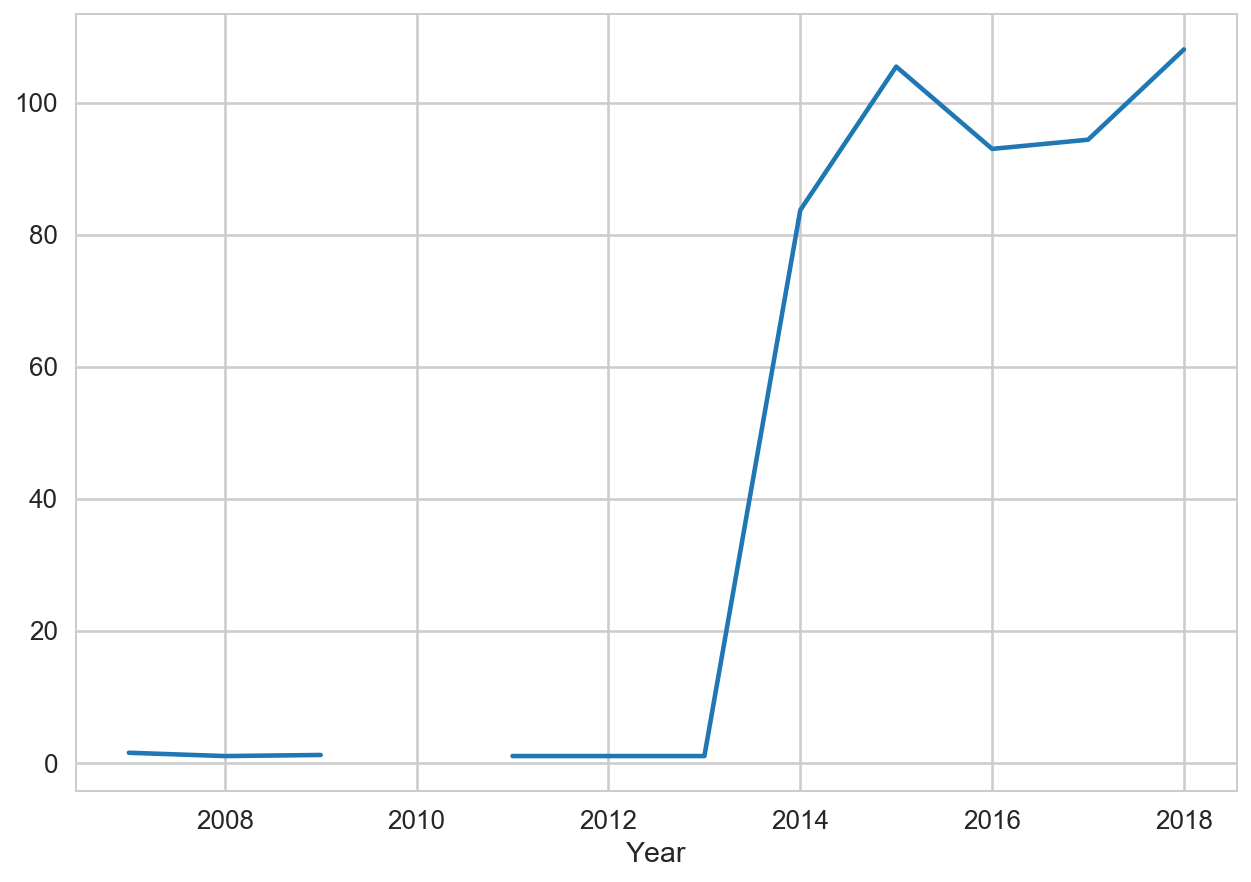

In [27]:
matplotlib.pyplot.xlabel("Year")
complaints_sample.StatusDate.value_counts().sort_index().resample('AS').mean().plot()

There was not enough data in the sample to form a continuous plot, so this is a plot of the number of complaints over time. Keep in mind that the data does not reach back as far as that of violations.

In [28]:
complaints['ReceivedDate'] = pd.to_datetime(complaints['ReceivedDate'], format="%m/%d/%Y", errors = 'coerce')
complaints['StatusDate'] = pd.to_datetime(complaints['StatusDate'], format="%m/%d/%Y", errors = 'coerce')

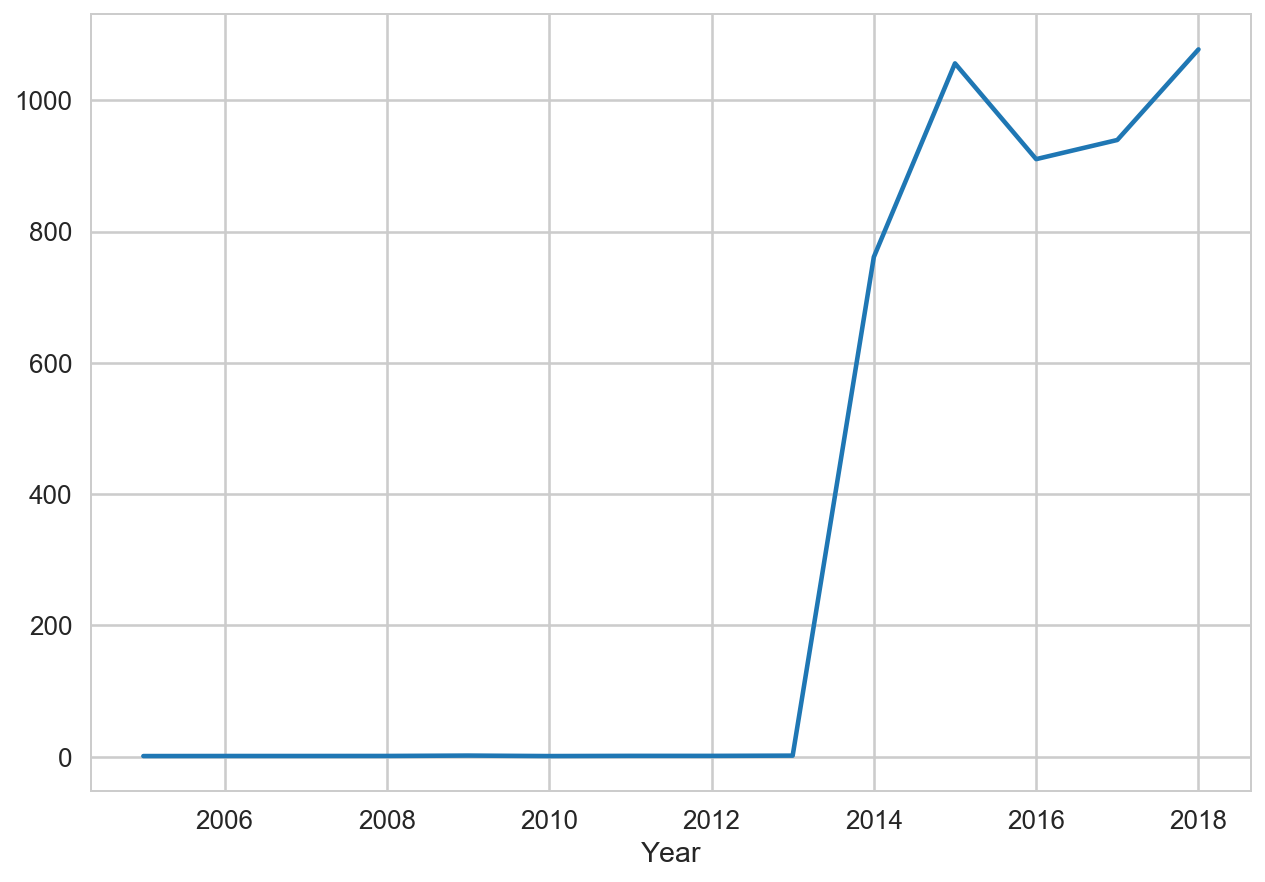

In [29]:
#complaints_trend = complaints_sample[(complaints_sample.StatusDate > '2015-01-01')]
matplotlib.pyplot.xlabel("Year")
complaints.StatusDate.value_counts().sort_index().resample('AS').mean().plot()

Let's take a look at the number of complaints in the five boroughs. The distribution mimics that of the violations above, where Brooklyn has the most number of complaints.

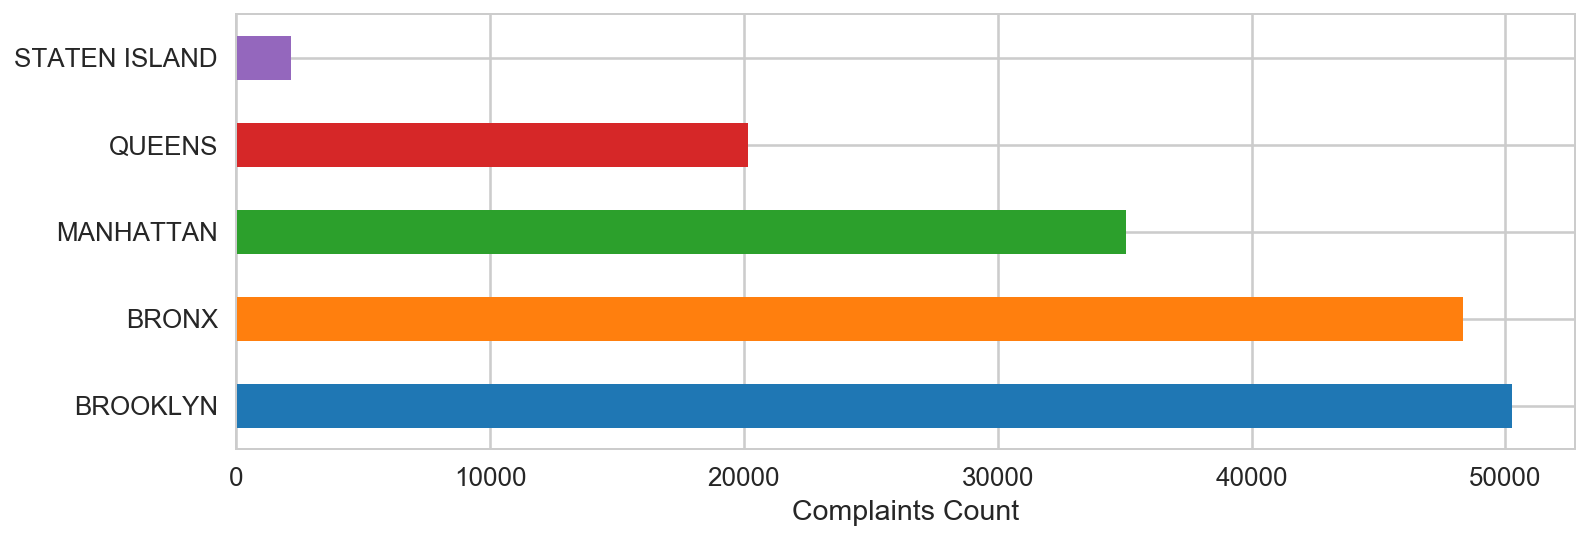

In [15]:
matplotlib.pyplot.xlabel("Complaints Count")
complaints_sample.Borough.value_counts().plot(kind='barh', figsize=(12,4))